In [1]:
import xarray as xr

In [3]:
xr.open_dataset('/home/lilianschuster/Schreibtisch/PhD/bayes_2022/calib_winter_mb/oggm_folder_from_cluster/per_glacier/RGI60-02/RGI60-02.01/RGI60-02.01104/gcm_data_monthly_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126_no_correction.nc')

<xarray.Dataset>
Dimensions:   (time: 3012)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2100-12-01
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    gradient  (time) float32 ...
    temp_std  (time) float32 ...
Attributes:
    ref_hgt:         1263.0
    ref_pix_lon:     -122.75
    ref_pix_lat:     50.25
    ref_pix_dis:     21474.268859396434
    climate_source:  _monthly_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126_no_correcti...
    hydro_yr_0:      1850
    hydro_yr_1:      2100
    author:          OGGM
    author_info:     Open Global Glacier Model

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.core import massbalance, flowline, climate
from oggm.utils import (floatyear_to_date, date_to_floatyear)

# just for the graphics
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, process_era5_daily_data, TIModel, TIModel_Sfc_Type, BASENAMES
# from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq
from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, melt_f_calib_geod_prep_inversion
from MBsandbox.flowline_TIModel import (run_from_climate_data_TIModel, run_constant_climate_TIModel,
                                        run_random_climate_TIModel)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False

working_dir = utils.gettempdir(dirname='OGGM_hydro', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# as we calibrate to geodetic estimates we use calendar years!  
# need to check if this works in southern hemisphere
cfg.PARAMS['hydro_month_nh'] = 1


# get the geodetic calibration data
pd_geodetic = utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


2021-10-27 09:40:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-10-27 09:40:49: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-10-27 09:40:49: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-10-27 09:40:49: oggm.cfg: Multiprocessing switched ON after user settings.
2021-10-27 09:40:49: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2021-10-27 09:40:49: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv verified successfully.


In [2]:
# check how many glaciers have geodetic msm
area_geod_11 = pd_geodetic[pd_geodetic.reg == 11].loc[pd_geodetic[pd_geodetic.reg == 11].dmdtda.dropna().index].area.sum()
area_all_11 = pd_geodetic[pd_geodetic.reg == 11].area.sum()
relative_area_11 = area_geod_11/area_all_11
relative_area_11

0.995049102691686

In [3]:
#df = ['RGI60-11.00890', 
#df = ['RGI60-11.00897'] # list of glaciers -> can be longer ... 
df = ['RGI60-11.01450'] # list of glaciers -> can be longer ... 

# this has to be done just once for a region (basin) (independent of climate, mb_type, prcp-fac ... )
init = True
if init:
    gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=40,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
else:
    gdirs = workflow.init_glacier_directories(df)

2021-10-27 09:40:51: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-10-27 09:40:51: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2021-10-27 09:40:51: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_040/L2/RGI60-11/RGI60-11.01.tar verified successfully.
2021-10-27 09:40:51: oggm.workflow: Execute entity tasks [compute_downstream_line] on 1 glaciers
2021-10-27 09:40:51: oggm.core.centerlines: (RGI60-11.01450) compute_downstream_line
2021-10-27 09:40:51: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 1 glaciers
2021-10-27 09:40:51: oggm.core.centerlines: (RGI60-11.01450) compute_downstream_bedshape


In [4]:
# if you have a precipitation factor from the hydrological model you can change it here
pf = 2  # we set the precipitation factor here to 1
climate_type = 'W5E5' #W5E5 # 'WFDE5_CRU'
#climate_type='WFDE5_CRU' -> need to use other pf and temp_bias ... 
#mb_type = 'mb_real_daily' #real daily input, this would be monthly input:'mb_monthly' #'mb_real_daily' # 'mb_monthly'#
mb_type = 'mb_monthly'
#grad_type ='var_an_cycle' # variable lapse rates
grad_type = 'cte'
ensemble = 'mri-esm2-0_r1i1p1f1'
ssp = 'ssp126'
dataset = climate_type

In [ ]:


# this has to be done once for each climate, mb_type, grad_type, pf option,
# then you can save the melt_f and a-factor for the runs later on 

if climate_type =='W5E5' or climate_type == 'W5E5_MSWEP':
    ye=2020 # till end of 2019
else:
    ye=2019
    
if mb_type == 'mb_real_daily':
    temporal_resol = 'daily'
else:
    temporal_resol = 'monthly'

# get the climate data (either w5e5 or WFDE5_CRU)
workflow.execute_entity_task(process_w5e5_data, gdirs,
                             temporal_resol=temporal_resol, climate_type=climate_type)
workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                             ssp = ssp, temporal_resol =temporal_resol,
                              climate_historical_filesuffix='_{}_{}'.format(temporal_resol, dataset) );

2021-10-27 09:40:52: oggm.workflow: Execute entity tasks [process_w5e5_data] on 1 glaciers
2021-10-27 09:40:52: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.01450) process_w5e5_data
2021-10-27 09:40:52: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2021-10-27 09:40:52: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2021-10-27 09:40:52: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc


In [18]:
gdirs[-1].get_climate_info(input_filesuffix='_{}_{}'.format(temporal_resol, dataset))

TypeError: get_diagnostics() got an unexpected keyword argument 'input_filesuffix'

In [6]:
from MBsandbox.mbmod_daily_oneflowline import MultipleFlowlineMassBalance_TIModel

In [7]:
run = False
if run:
    # just for testing
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':0.5, 'spinup_yrs':6, 'melt_f_update':'monthly',
                               'melt_f_ratio_snow_to_ice':0.5}
    mb_model_sub_class = TIModel_Sfc_Type
    precipitation_factor = pf
    fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
    melt_f_chosen = 250 # gdirs[-1].read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2']
    climate_filename = 'gcm_data'
    bias = 0
    climate_input_filesuffix = '{}_{}_{}'.format('ISIMIP3b', ensemble, ssp)

    mb = MultipleFlowlineMassBalance_TIModel(gdirs[-1], mb_model_class=mb_model_sub_class,
                                             prcp_fac=precipitation_factor,
                                             melt_f=melt_f_chosen,
                                             filename=climate_filename,
                                             bias=bias,
                                             input_filesuffix=climate_input_filesuffix,
                                             mb_type=mb_type,
                                             grad_type=grad_type,
                                             # check_calib_params=check_calib_params,
                                             **kwargs_for_TIModel_Sfc_Type)
    #mb.flowline_mb_models[-1].reset_pd_mb_bucket(init_model_fls = gdirs[-1].read_pickle('model_flowlines'))
    #mb.flowline_mb_models[-1].pd_bucket.index
    #mb.flowline_mb_models[-1].reset_pd_mb_bucket()
    #mb.flowline_mb_models[-1].pd_bucket

In [ ]:
#xr.open_dataset('/tmp/OGGM/OGGM_hydro/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/gcm_data_daily_ISIMIP3b_mri-esm2-0_r1i1p1f1_ssp126.nc')
# xr.open_dataset('/tmp/OGGM/OGGM_hydro/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/model_geometrysfc_type_linear_tau_0.5_monthly_update_ISIMIP3b_W5E5_mri-esm2-0_r1i1p1f1_mb_real_daily_var_an_cyclepf2_historical_test.nc')

In [8]:
def calib_inv_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear', 'tau_e_fold_yr':0.5, 'spinup_yrs':6, 'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5}, mb_elev_feedback = 'annual'):
    
    #ye_h = 2014
    y0 = 1979
    ye = 2100
    ye_calib = 2020
    nosigmaadd = ''
    workflow.execute_entity_task(melt_f_calib_geod_prep_inversion, gdirs, 
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=ye_calib,
                                mb_model_sub_class=TIModel_Sfc_Type,
                                kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type)

    # here glen-a is calibrated to mathch gdirs glaciers in total
    border = 80
    filter = border >= 20
    pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                          apply_fs_on_mismatch=False,
                                                          error_on_mismatch=False,
                                                          filter_inversion_output=filter)
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])

    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)
    
    ###### 

    add_msm = 'sfc_type_{}_tau_{}_{}_update_ratio{}_mb_fb_{}'.format(kwargs_for_TIModel_Sfc_Type['melt_f_change'],
                                                    kwargs_for_TIModel_Sfc_Type['tau_e_fold_yr'],
                                                    kwargs_for_TIModel_Sfc_Type['melt_f_update'],
                                                   kwargs_for_TIModel_Sfc_Type['melt_f_ratio_snow_to_ice'], mb_elev_feedback)
    j = 'test'

    add = 'pf{}'.format(pf)

    fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
    gdir = gdirs[-1]
    gdir.read_json(filename='melt_f_geod', filesuffix=fs)
    rid = '{}_{}_{}'.format('ISIMIP3b', ensemble, ssp)
    run_from_climate_data_TIModel(gdirs[-1], bias=0, min_ys=y0,
                                  ye=ye,
                                  mb_type=mb_type,
                                  climate_filename='gcm_data',
                                  grad_type=grad_type, precipitation_factor=pf, 
                                  melt_f=gdir.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2'], 
                                  climate_input_filesuffix= rid, #dataset,
                                  output_filesuffix='_{}{}_ISIMIP3b_{}_{}_{}_{}{}_hist_{}_{}'.format(nosigmaadd,add_msm,
                                              dataset, ensemble, mb_type, grad_type, add, ssp, j),
                             mb_model_sub_class = TIModel_Sfc_Type,
                             kwargs_for_TIModel_Sfc_Type = kwargs_for_TIModel_Sfc_Type, #{'melt_f_change':'linear'},
                             mb_elev_feedback = mb_elev_feedback)
    ds = utils.compile_run_output(gdirs, input_filesuffix='_{}{}_ISIMIP3b_{}_{}_{}_{}{}_hist_{}_{}'.format(nosigmaadd,add_msm,
                                              dataset, ensemble, mb_type, grad_type, add, ssp, j))
    
    #init_model_filesuffix='{}{}_ISIMIP3b_{}_{}_{}_{}{}_historical_{}'.format(nosigmaadd,add_msm,
    
    return ds, gdir.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2']

In [9]:
def calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=200,
                     spinup=True, interpolation_optim=False):
    
    #ye_h = 2014
    y0 = 1979
    ye = 2100
    ye_calib = 2020
    nosigmaadd = ''
    kwargs_for_TIModel_Sfc_Type_calib = kwargs_for_TIModel_Sfc_Type.copy()
    kwargs_for_TIModel_Sfc_Type_calib['interpolation_optim'] = False
    workflow.execute_entity_task(melt_f_calib_geod_prep_inversion, gdirs, 
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=ye_calib,
                                mb_model_sub_class=TIModel_Sfc_Type,
                                kwargs_for_TIModel_Sfc_Type=kwargs_for_TIModel_Sfc_Type_calib,
                                spinup=spinup)

    # here glen-a is calibrated to mathch gdirs glaciers in total
    border = 80
    filter = border >= 20
    pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                          apply_fs_on_mismatch=False,
                                                          error_on_mismatch=False,
                                                          filter_inversion_output=filter)
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])

    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)
    
    ###### 

    add_msm = 'sfc_type_{}_tau_{}_{}_update_ratio{}_mb_fb_{}'.format(kwargs_for_TIModel_Sfc_Type['melt_f_change'],
                                                    kwargs_for_TIModel_Sfc_Type['tau_e_fold_yr'],
                                                    kwargs_for_TIModel_Sfc_Type['melt_f_update'],
                                                   kwargs_for_TIModel_Sfc_Type['melt_f_ratio_snow_to_ice'], mb_elev_feedback)
    j = 'test'

    add = 'pf{}'.format(pf)

    fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
    gdir = gdirs[-1]
    gdir.read_json(filename='melt_f_geod', filesuffix=fs)
    rid = '{}_{}_{}'.format('ISIMIP3b', ensemble, ssp)
    run_constant_climate_TIModel(gdirs[-1], bias=0, nyears=nyears, 
                                 y0=2003, halfsize=15,
                                  mb_type=mb_type,
                                  climate_filename='gcm_data',
                                  grad_type=grad_type, precipitation_factor=pf, 
                                  melt_f=gdir.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2'], 
                                  climate_input_filesuffix= rid, #dataset,
                                  output_filesuffix='_{}{}_ISIMIP3b_{}_{}_{}_{}{}_hist_{}_{}'.format(nosigmaadd,add_msm,
                                              dataset, ensemble, mb_type, grad_type, add, ssp, j),
                             mb_model_sub_class = TIModel_Sfc_Type,
                             kwargs_for_TIModel_Sfc_Type = kwargs_for_TIModel_Sfc_Type, #{'melt_f_change':'linear'},
                             mb_elev_feedback = mb_elev_feedback, interpolation_optim = interpolation_optim)
    ds = utils.compile_run_output(gdirs, input_filesuffix='_{}{}_ISIMIP3b_{}_{}_{}_{}{}_hist_{}_{}'.format(nosigmaadd,add_msm,
                                              dataset, ensemble, mb_type, grad_type, add, ssp, j))
    
    #init_model_filesuffix='{}{}_ISIMIP3b_{}_{}_{}_{}{}_historical_{}'.format(nosigmaadd,add_msm,
    
    return ds, gdir.read_json(filename='melt_f_geod', filesuffix=fs)['melt_f_pf_2']

In [12]:
ds_linear_an_optim, melt_f_linear_an_optim = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual', 
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=100,
                     spinup=True,interpolation_optim=True)
ds_neg_exp_an_optim, melt_f_neg_exp_an_optim = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=100,
                     spinup=True,interpolation_optim=True)

2021-08-09 10:01:42: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-09 10:01:42: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-09 10:01:44: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-09 10:01:45: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-09 10:01:45: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-09 10:01:45: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-09 10:01:45: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-09 10:01:45: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-09 10:01:45: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-09 10:01:45: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-09 10:01:45: oggm.workflow: Execute entity task filter_inversion_out

TypeError: __call__() got an unexpected keyword argument 'fls'

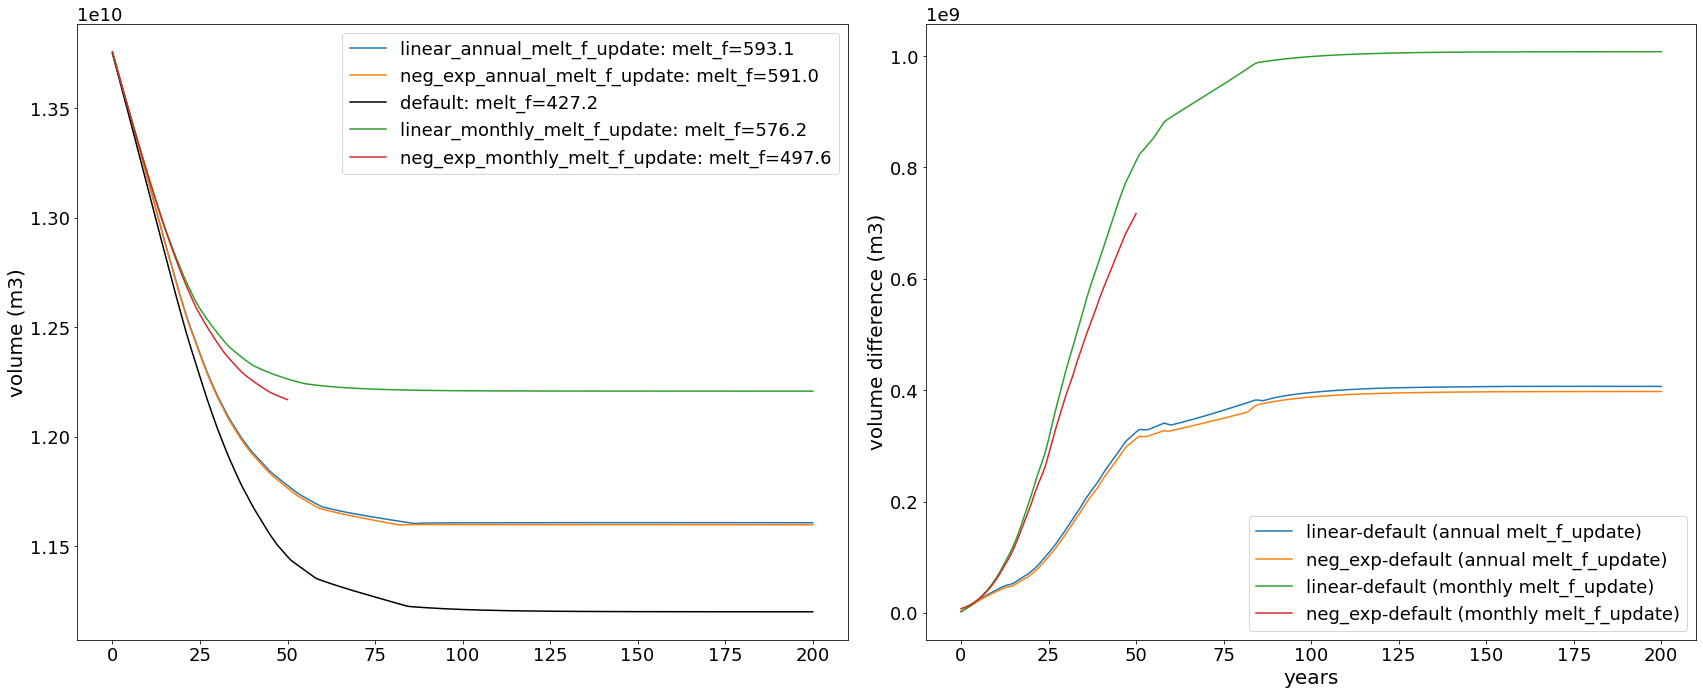

In [37]:
plt.figure(figsize=(24,10))
plt.subplot(121)
plt.plot(ds_linear_an.volume, label = 'linear_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_an))
plt.plot(ds_neg_exp_an.volume, label = 'neg_exp_annual_melt_f_update: melt_f={:0.1f}'.format(melt_f_neg_exp_an))
plt.plot(ds_default.volume, label = 'default: melt_f={:0.1f}'.format(melt_f_default), color = 'black')

plt.plot(ds_linear_m.volume, label = 'linear_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_linear_m))
plt.plot(ds_neg_exp_m.volume, label = 'neg_exp_monthly_melt_f_update: melt_f={:0.1f}'.format(melt_f_neg_exp_m))
plt.ylabel('volume (m3)')
plt.legend()
plt.subplot(122)
plt.plot(ds_linear_an.volume-ds_default.volume, label = 'linear-default (annual melt_f_update)')
plt.plot(ds_neg_exp_an.volume-ds_default.volume, label = 'neg_exp-default (annual melt_f_update)')
plt.plot(ds_linear_m.volume-ds_default.volume, label = 'linear-default (monthly melt_f_update)')
plt.plot(ds_neg_exp_m.volume-ds_default.volume, label = 'neg_exp-default (monthly melt_f_update)')

plt.ylabel('volume difference (m3)')
plt.xlabel('years')
plt.legend()
plt.tight_layout()

In [13]:
melt_f_neg_exp_an

591.0260850406772

In [22]:
ds_default, melt_f_default = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear','tau_e_fold_yr':20,
                                                     'spinup_yrs':0,
                                                     'melt_f_update':'annual', 
                               'melt_f_ratio_snow_to_ice':1},
                      mb_elev_feedback = 'annual',
                     nyears=200,
                     )

2021-08-05 20:41:46: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-05 20:41:46: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-05 20:41:49: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-05 20:41:49: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-05 20:41:49: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-05 20:41:49: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-05 20:41:49: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-05 20:41:49: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-05 20:41:49: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-05 20:41:49: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-05 20:41:49: oggm.workflow: Execute entity task filter_inversion_out

In [30]:
ds_neg_exp_m_m, melt_f_neg_exp_m_m = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'monthly',
                     nyears=50,
                     spinup=True)

2021-08-06 09:51:58: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-06 09:51:58: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-06 09:55:41: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-06 09:56:05: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-06 09:56:06: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-06 09:56:06: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-06 09:56:06: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-06 09:56:06: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-06 09:56:06: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-06 09:56:06: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-06 09:56:06: oggm.workflow: Execute entity task filter_inversion_out

NotImplementedError: need to implement it for TIModel_Sfc_Type

In [31]:
ds_neg_exp_m, melt_f_neg_exp_m = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=50,
                     spinup=True)

2021-08-06 09:57:03: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-06 09:57:03: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-06 10:00:42: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-06 10:01:12: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-06 10:01:12: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-06 10:01:12: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-06 10:01:12: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-06 10:01:12: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-06 10:01:12: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-06 10:01:12: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-06 10:01:12: oggm.workflow: Execute entity task filter_inversion_out

In [19]:
ds_linear_m, melt_f_linear_m = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':6,
                                                     'melt_f_update':'monthly', 
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=200,
                     spinup=True)


2021-08-05 16:23:04: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-05 16:23:04: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-05 16:25:59: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-05 16:26:23: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-05 16:26:23: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-05 16:26:23: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-05 16:26:23: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-05 16:26:23: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-05 16:26:23: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-05 16:26:23: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-05 16:26:23: oggm.workflow: Execute entity task filter_inversion_out

KeyboardInterrupt: 

In [47]:
from MBsandbox.mbmod_daily_oneflowline import ConstantMassBalance_TIModel
kwargs_for_TIModel_Sfc_Type = {'melt_f_change': 'linear',
                               'tau_e_fold_yr': 0.5,
                               'spinup_yrs': 6,
                               'melt_f_update': 'annual',
                               'melt_f_ratio_snow_to_ice': 0.5,
                               }
rid = '_monthly_W5E5'
gdir = gdirs[-1]
mb_mod = ConstantMassBalance_TIModel(gdir, melt_f = 300, prcp_fac=1,
                            mb_model_sub_class=TIModel_Sfc_Type, residual=0,
                            #nyears=20,
                                     y0=2010, halfsize=3,
                            #output_filesuffix='_annual',
                            #climate_
                            #input_filesuffix=rid,
                            baseline_climate=dataset,
                            mb_type=mb_type, grad_type=grad_type,
                            **kwargs_for_TIModel_Sfc_Type
                            )
h, w = gdir.get_inversion_flowline_hw()
mb, pd_bucket = mb_mod.get_annual_mb(h, spinup=False, bucket_output = True)
mb_spinup, pd_bucket_spinup = mb_mod.get_annual_mb(h, spinup=True, bucket_output = True)

In [48]:
np.any(pd_bucket - pd_bucket_spinup != 0)

False

In [49]:
pd_bucket-pd_bucket_spinup

,snow,firn_yr_1,firn_yr_2,firn_yr_3,firn_yr_4,firn_yr_5,delta_kg/m2
distance_along_flowline,,,,,,,
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
822.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1096.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
17536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18084.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
mb_mod.mbmod.pd_mb_annual

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
distance_along_flowline,,,,,,,,,,,,,,,,,
0.0,1.828676e-07,1.830017e-07,1.748990e-07,2.255023e-07,1.776081e-07,1.537429e-07,1.590104e-07,2.366017e-07,1.821794e-07,1.991575e-07,2.297669e-07,1.350575e-07,1.768344e-07,1.557282e-07,1.537429e-07,1.889309e-07,1.857526e-07
274.0,1.828676e-07,1.830017e-07,1.710869e-07,2.255023e-07,1.776081e-07,1.537429e-07,1.590104e-07,2.366017e-07,1.821794e-07,1.991575e-07,2.297669e-07,1.307853e-07,1.768344e-07,1.557282e-07,1.467026e-07,1.889309e-07,1.857526e-07
548.0,1.756006e-07,1.830017e-07,1.641016e-07,2.205689e-07,1.776081e-07,1.537429e-07,1.590104e-07,2.366017e-07,1.821794e-07,1.991575e-07,2.297669e-07,1.248125e-07,1.768344e-07,1.557282e-07,1.404649e-07,1.889309e-07,1.857526e-07
822.0,1.656742e-07,1.830017e-07,1.526977e-07,2.121918e-07,1.776081e-07,1.523065e-07,1.590104e-07,2.366017e-07,1.821794e-07,1.977429e-07,2.297669e-07,1.102793e-07,1.768344e-07,1.557282e-07,1.355378e-07,1.889309e-07,1.857526e-07
1096.0,1.585129e-07,1.830017e-07,1.398115e-07,2.061483e-07,1.776081e-07,1.457814e-07,1.588391e-07,2.364348e-07,1.792549e-07,1.913149e-07,2.295411e-07,9.968149e-08,1.768344e-07,1.557282e-07,1.319833e-07,1.889309e-07,1.857526e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17536.0,-4.584532e-07,-4.960498e-07,-5.683409e-07,-3.705934e-07,-4.259033e-07,-5.055094e-07,-5.164574e-07,-4.140769e-07,-5.473571e-07,-4.438558e-07,-4.829514e-07,-6.065047e-07,-5.092974e-07,-5.777690e-07,-6.282557e-07,-5.220054e-07,-4.532578e-07
17810.0,-4.992587e-07,-5.236496e-07,-5.987074e-07,-3.986180e-07,-4.509033e-07,-5.374215e-07,-5.443787e-07,-4.425942e-07,-5.732661e-07,-4.636990e-07,-5.229629e-07,-6.441310e-07,-5.361620e-07,-6.050639e-07,-6.609714e-07,-5.451559e-07,-4.819461e-07
18084.0,-5.476591e-07,-5.539113e-07,-6.387266e-07,-4.338077e-07,-4.822951e-07,-5.774926e-07,-5.794388e-07,-4.784025e-07,-6.133884e-07,-4.943103e-07,-5.741783e-07,-6.939688e-07,-5.698952e-07,-6.393374e-07,-7.020517e-07,-5.742253e-07,-5.179691e-07


In [20]:
(mb -  mb_spinup)/mb_spinup

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.33687430e-16,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.54668866e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.55910656e-16,
       -6.35396065e-04,  1.76564784e-01,  7.29922022e-02,  5.90362536e-02,
        5.20729171e-02,  4.21181064e-02,  3.88775992e-02,  3.15788225e-02,
        1.90830262e-02,  8.75246670e-03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [14]:
mb_mod.mbmod.pd_mb_annual

,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
distance_along_flowline,,,,,,,,,,,
0.0,1.590104e-07,2.366017e-07,1.821794e-07,1.991575e-07,2.297669e-07,1.350575e-07,1.768344e-07,1.557282e-07,1.537429e-07,1.889309e-07,1.857526e-07
274.0,1.590104e-07,2.366017e-07,1.821794e-07,1.991575e-07,2.297669e-07,1.307853e-07,1.768344e-07,1.557282e-07,1.467026e-07,1.889309e-07,1.857526e-07
548.0,1.590104e-07,2.366017e-07,1.821794e-07,1.991575e-07,2.297669e-07,1.248125e-07,1.768344e-07,1.557282e-07,1.404649e-07,1.889309e-07,1.857526e-07
822.0,1.590104e-07,2.366017e-07,1.821794e-07,1.977429e-07,2.297669e-07,1.102793e-07,1.768344e-07,1.557282e-07,1.355378e-07,1.889309e-07,1.857526e-07
1096.0,1.588391e-07,2.364348e-07,1.792549e-07,1.913149e-07,2.295411e-07,9.968149e-08,1.768344e-07,1.557282e-07,1.319833e-07,1.889309e-07,1.857526e-07
...,...,...,...,...,...,...,...,...,...,...,...
17536.0,-5.164574e-07,-4.140769e-07,-5.473571e-07,-4.438558e-07,-4.829514e-07,-6.065047e-07,-5.092974e-07,-5.777690e-07,-6.282557e-07,-5.220054e-07,-4.532578e-07
17810.0,-5.443787e-07,-4.425942e-07,-5.732661e-07,-4.636990e-07,-5.229629e-07,-6.441310e-07,-5.361620e-07,-6.050639e-07,-6.609714e-07,-5.451559e-07,-4.819461e-07
18084.0,-5.794388e-07,-4.784025e-07,-6.133884e-07,-4.943103e-07,-5.741783e-07,-6.939688e-07,-5.698952e-07,-6.393374e-07,-7.020517e-07,-5.742253e-07,-5.179691e-07


In [12]:
mb_mod.mbmod.pd_bucket

,snow,firn_yr_1,firn_yr_2,firn_yr_3,firn_yr_4,firn_yr_5,delta_kg/m2
distance_along_flowline,,,,,,,
0.0,0,5272.10437,5362.312637,4363.591770,4419.938721,5018.984436,NaN
274.0,0,5272.10437,5362.312637,4163.770932,4419.938721,5018.984436,NaN
548.0,0,5272.10437,5362.312637,3986.731044,4419.938721,5018.984436,NaN
822.0,0,5272.10437,5362.312637,3846.889271,4419.938721,5018.984436,NaN
1096.0,0,5272.10437,5362.312637,3746.003405,4419.938721,5018.984436,NaN
...,...,...,...,...,...,...,...
17536.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
17810.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,NaN
18084.0,0,0.00000,0.000000,0.000000,0.000000,0.000000,NaN


In [10]:
ds_nospinup, melt_f_nospinup = calib_inv_cte_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear',
                                                     'tau_e_fold_yr':0.5,
                                                     'spinup_yrs':0,
                                                     'melt_f_update':'annual',
                               'melt_f_ratio_snow_to_ice':0.5},
                      mb_elev_feedback = 'annual',
                     nyears=200, spinup=False)

2021-08-05 13:23:44: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-05 13:23:44: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-05 13:23:46: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-05 13:23:46: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-05 13:23:46: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-05 13:23:46: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-05 13:23:46: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-05 13:23:46: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-05 13:23:46: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-05 13:23:46: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-05 13:23:46: oggm.workflow: Execute entity task filter_inversion_out

In [11]:
ds, melt_f = calib_inv_cte_run(nyears=200)

2021-08-05 13:24:35: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-05 13:24:35: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-05 13:24:37: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-05 13:24:37: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-05 13:24:37: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-05 13:24:37: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-05 13:24:37: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-05 13:24:37: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-05 13:24:37: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-05 13:24:37: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-05 13:24:37: oggm.workflow: Execute entity task filter_inversion_out

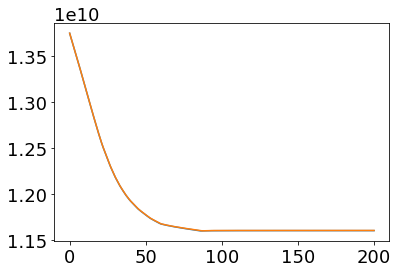

In [12]:
plt.plot(ds.volume)
plt.plot(ds_nospinup.volume)

Text(0, 0.5, 'relative deviation in %\n (no spinup vs spinup)')

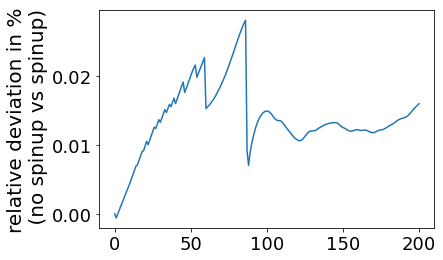

In [30]:
plt.plot((ds_nospinup.volume-ds.volume)*100/ ds.volume)
plt.ylabel('relative volume deviation in %\n (no spinup vs spinup)')


In [22]:
melt_f

593.0579722340237

In [24]:
melt_f_nospinup

592.9669043345316

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:2894: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mb_on_h += self.mbmod.get_annual_mb(heights,


ValueError: could not broadcast input array from shape (69,7) into shape (69,)

In [34]:
mb_mod.pd_bu

array([ 1.82069295e-07,  1.81040885e-07,  1.79930839e-07,  1.78033121e-07,
        1.75845061e-07,  1.69629859e-07,  1.60054000e-07,  1.45874022e-07,
        1.31805031e-07,  1.22122430e-07,  1.11685211e-07,  9.89987601e-08,
        8.52046812e-08,  7.46335873e-08,  6.77009128e-08,  6.09738129e-08,
        5.50192427e-08,  4.93947602e-08,  4.27845958e-08,  3.54987824e-08,
        2.89480104e-08,  2.30288975e-08,  1.71157166e-08,  1.06109567e-08,
        3.87258579e-09, -1.47977746e-09, -7.15060403e-09, -1.38540576e-08,
       -2.14491753e-08, -3.17584382e-08, -4.32584566e-08, -5.59253934e-08,
       -6.72603179e-08, -7.96040458e-08, -9.39690532e-08, -1.08713526e-07,
       -1.20148977e-07, -1.30712024e-07, -1.39568202e-07, -1.48932456e-07,
       -1.58924044e-07, -1.69054408e-07, -1.79572476e-07, -1.91318565e-07,
       -2.04188618e-07, -2.16896675e-07, -2.29192508e-07, -2.41328370e-07,
       -2.54139798e-07, -2.67550337e-07, -2.81627748e-07, -2.97365957e-07,
       -3.11291506e-07, -

In [21]:
np.testing.assert_allclose(ds.volume.isel(rgi_id=0).values,
                           ds_nospinup.volume.isel(rgi_id=0).values)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 200 / 201 (99.5%)
Max absolute difference: 3260848.36463737
Max relative difference: 0.00028094
 x: array([1.375265e+10, 1.369657e+10, 1.364034e+10, 1.358403e+10,
       1.352755e+10, 1.347081e+10, 1.341374e+10, 1.335630e+10,
       1.329848e+10, 1.324032e+10, 1.318190e+10, 1.312324e+10,...
 y: array([1.375266e+10, 1.369649e+10, 1.364034e+10, 1.358411e+10,
       1.352770e+10, 1.347104e+10, 1.341405e+10, 1.335668e+10,
       1.329893e+10, 1.324084e+10, 1.318249e+10, 1.312391e+10,...

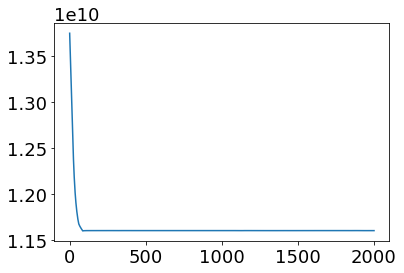

In [16]:
plt.plot(ds.volume)
plt.plot(ds_nospinup.volume)

In [12]:
run = True
if run:

    ds = {}
    ds_ratio1 = {}
    melt_fs = {}
    melt_fs_ratio1 = {}
    for update in ['monthly']: # 'annual', 
        for mfc in ['linear', 'neg_exp']:
            for tau in [1]:
            #for update in ['annual']: # 'annual', 
                for mb_el_fb in ['annual']:
                    v, melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = calib_inv_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':mfc, 'tau_e_fold_yr':tau,
                                                                                                                      'spinup_yrs':6, 'melt_f_update':update,
                                       'melt_f_ratio_snow_to_ice':0.5}, mb_elev_feedback=mb_el_fb)
                    ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = v.volume.values.squeeze()
                    v, melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = calib_inv_run(kwargs_for_TIModel_Sfc_Type = {'melt_f_change':mfc, 'tau_e_fold_yr':tau,
                                                                                                                             'spinup_yrs':6, 'melt_f_update':update,
                                       'melt_f_ratio_snow_to_ice':1}, mb_elev_feedback=mb_el_fb)
                    ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)] = v.volume.values.squeeze()
        pd_ds_ratio1 = pd.DataFrame(ds_ratio1, index =np.arange(2004,2101,1))

        pd_ds_ratio1.to_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio1_{}_{}_new.csv'.format(update, mb_type, grad_type))
        pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
        pd_ds.to_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio05_{}_{}_new.csv'.format(update,mb_type, grad_type))
else:
    # need to decide here which update to use or instead just do 
    update = 'annual'
    pd_ds_ratio1 = pd.read_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio1_{}_{}_new.csv'.format(update,mb_type, grad_type), index_col='Unnamed: 0')
    pd_ds = pd.read_csv('sfc_type_dist_projections_aletsch_{}_melt_f_update_ratio05_{}_{}_new.csv'.format(update,mb_type, grad_type), index_col='Unnamed: 0')

2021-08-16 15:41:30: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 1 glaciers
2021-08-16 15:41:30: MBsandbox.help_func: (RGI60-11.01450) melt_f_calib_geod_prep_inversion
2021-08-16 15:43:43: oggm.core.climate: (RGI60-11.01450) apparent_mb_from_any_mb
2021-08-16 15:44:01: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2021-08-16 15:44:02: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-08-16 15:44:02: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2021-08-16 15:44:02: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2021-08-16 15:44:02: oggm.core.inversion: (RGI60-11.01450) prepare_for_inversion
2021-08-16 15:44:02: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2021-08-16 15:44:02: oggm.core.inversion: (RGI60-11.01450) mass_conservation_inversion
2021-08-16 15:44:02: oggm.workflow: Execute entity task filter_inversion_out

In [11]:
h,_ = gdirs[-1].get_inversion_flowline_hw()
len(h)

69

In [27]:
    pd_ds_ratio1.to_csv('sfc_type_dist_projections_aletsch_monthly_melt_f_update_ratio1.csv')
    pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
    pd_ds.to_csv('sfc_type_dist_projections_aletsch_monthly_melt_f_update_ratio05.csv')

In [54]:
pd_ds.loc[2100]

linear_tau0.5yr_updateannual_mb_fb_monthly     5.442433e+09
linear_tau0.5yr_updateannual_mb_fb_annual      6.068179e+09
linear_tau1yr_updateannual_mb_fb_monthly       5.442433e+09
linear_tau1yr_updateannual_mb_fb_annual        6.068179e+09
neg_exp_tau0.5yr_updateannual_mb_fb_monthly    5.228223e+09
neg_exp_tau0.5yr_updateannual_mb_fb_annual     6.039583e+09
neg_exp_tau1yr_updateannual_mb_fb_monthly      5.280485e+09
neg_exp_tau1yr_updateannual_mb_fb_annual       6.042461e+09
Name: 2100, dtype: float64

In [52]:
pd_ds_ratio1.loc[2100]

linear_tau0.5yr_updatemonthly_mb_fb_monthly     4.087301e+09
linear_tau0.5yr_updatemonthly_mb_fb_annual      4.087012e+09
linear_tau1yr_updatemonthly_mb_fb_monthly       4.087301e+09
linear_tau1yr_updatemonthly_mb_fb_annual        4.087012e+09
neg_exp_tau0.5yr_updatemonthly_mb_fb_monthly    4.087301e+09
neg_exp_tau0.5yr_updatemonthly_mb_fb_annual     4.087012e+09
neg_exp_tau1yr_updatemonthly_mb_fb_monthly      4.087301e+09
neg_exp_tau1yr_updatemonthly_mb_fb_annual       4.087012e+09
Name: 2100, dtype: float64

In [37]:
pd_ds.loc[2100]

linear_tau0.5yr_updateannual_mb_fb_monthly     5.086488e+09
linear_tau0.5yr_updateannual_mb_fb_annual      5.729938e+09
linear_tau1yr_updateannual_mb_fb_monthly       5.086488e+09
linear_tau1yr_updateannual_mb_fb_annual        5.729938e+09
neg_exp_tau0.5yr_updateannual_mb_fb_monthly    4.757858e+09
neg_exp_tau0.5yr_updateannual_mb_fb_annual     5.673224e+09
neg_exp_tau1yr_updateannual_mb_fb_monthly      4.833858e+09
neg_exp_tau1yr_updateannual_mb_fb_annual       5.680251e+09
Name: 2100, dtype: float64

In [28]:


    
pd_ds.loc[2100]


linear_tau0.5yr_updatemonthly_mb_fb_monthly     5.475492e+09
linear_tau0.5yr_updatemonthly_mb_fb_annual      5.479159e+09
linear_tau1yr_updatemonthly_mb_fb_monthly       5.475492e+09
linear_tau1yr_updatemonthly_mb_fb_annual        5.479159e+09
neg_exp_tau0.5yr_updatemonthly_mb_fb_monthly    4.582829e+09
neg_exp_tau0.5yr_updatemonthly_mb_fb_annual     4.579472e+09
neg_exp_tau1yr_updatemonthly_mb_fb_monthly      4.900912e+09
neg_exp_tau1yr_updatemonthly_mb_fb_annual       4.902159e+09
Name: 2100, dtype: float64

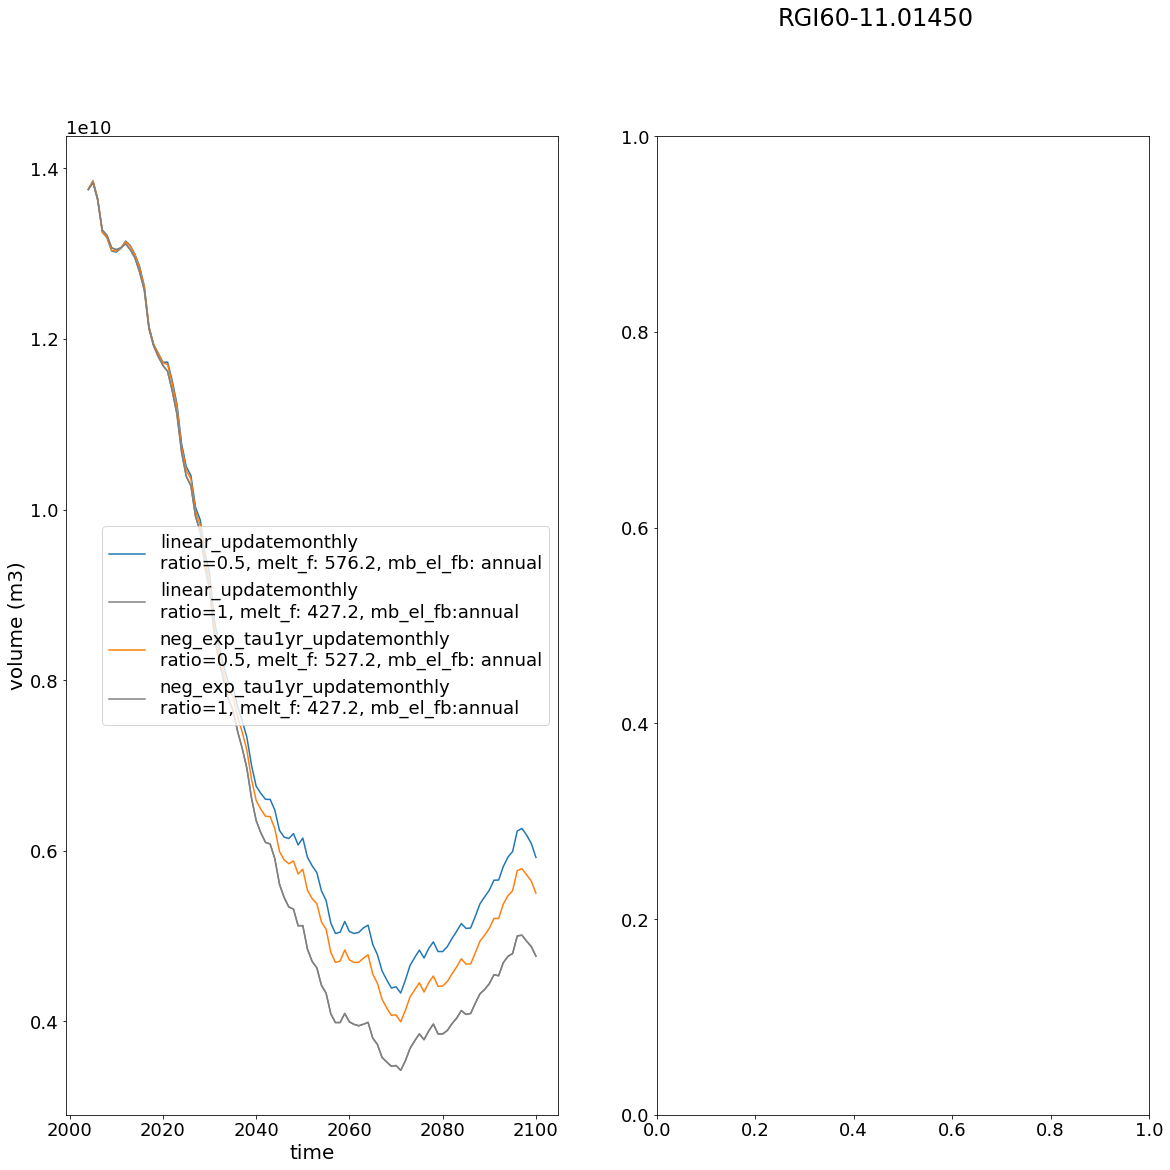

In [15]:
pd_ds_ratio1 = pd.DataFrame(ds_ratio1, index =np.arange(2004,2101,1))
#assert np.all(pd_ds_ratio1.std(axis=1) == 0)
#pd_ds[pd_ds.columns[2:]].std(axis=1)

plt.figure(figsize=(30,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
col={'annual':'grey', 'monthly':'black'}
plt.subplot(131)
for mb_el_fb in ['annual']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([1]):
                if mfc == 'linear' and tau == 0.5:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f = melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, update, melt_f, mb_el_fb)
                    else:
                        label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, tau, update, melt_f, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1), ds_plot,
                             label = label, ls = ls[j])
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, update, melt_f_1, mb_el_fb)
                    else:
                        label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, tau, update, melt_f_1, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1),
                             ds_plot_ratio1, label = label_1,
                             ls = ls[j], color=col[mb_el_fb])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

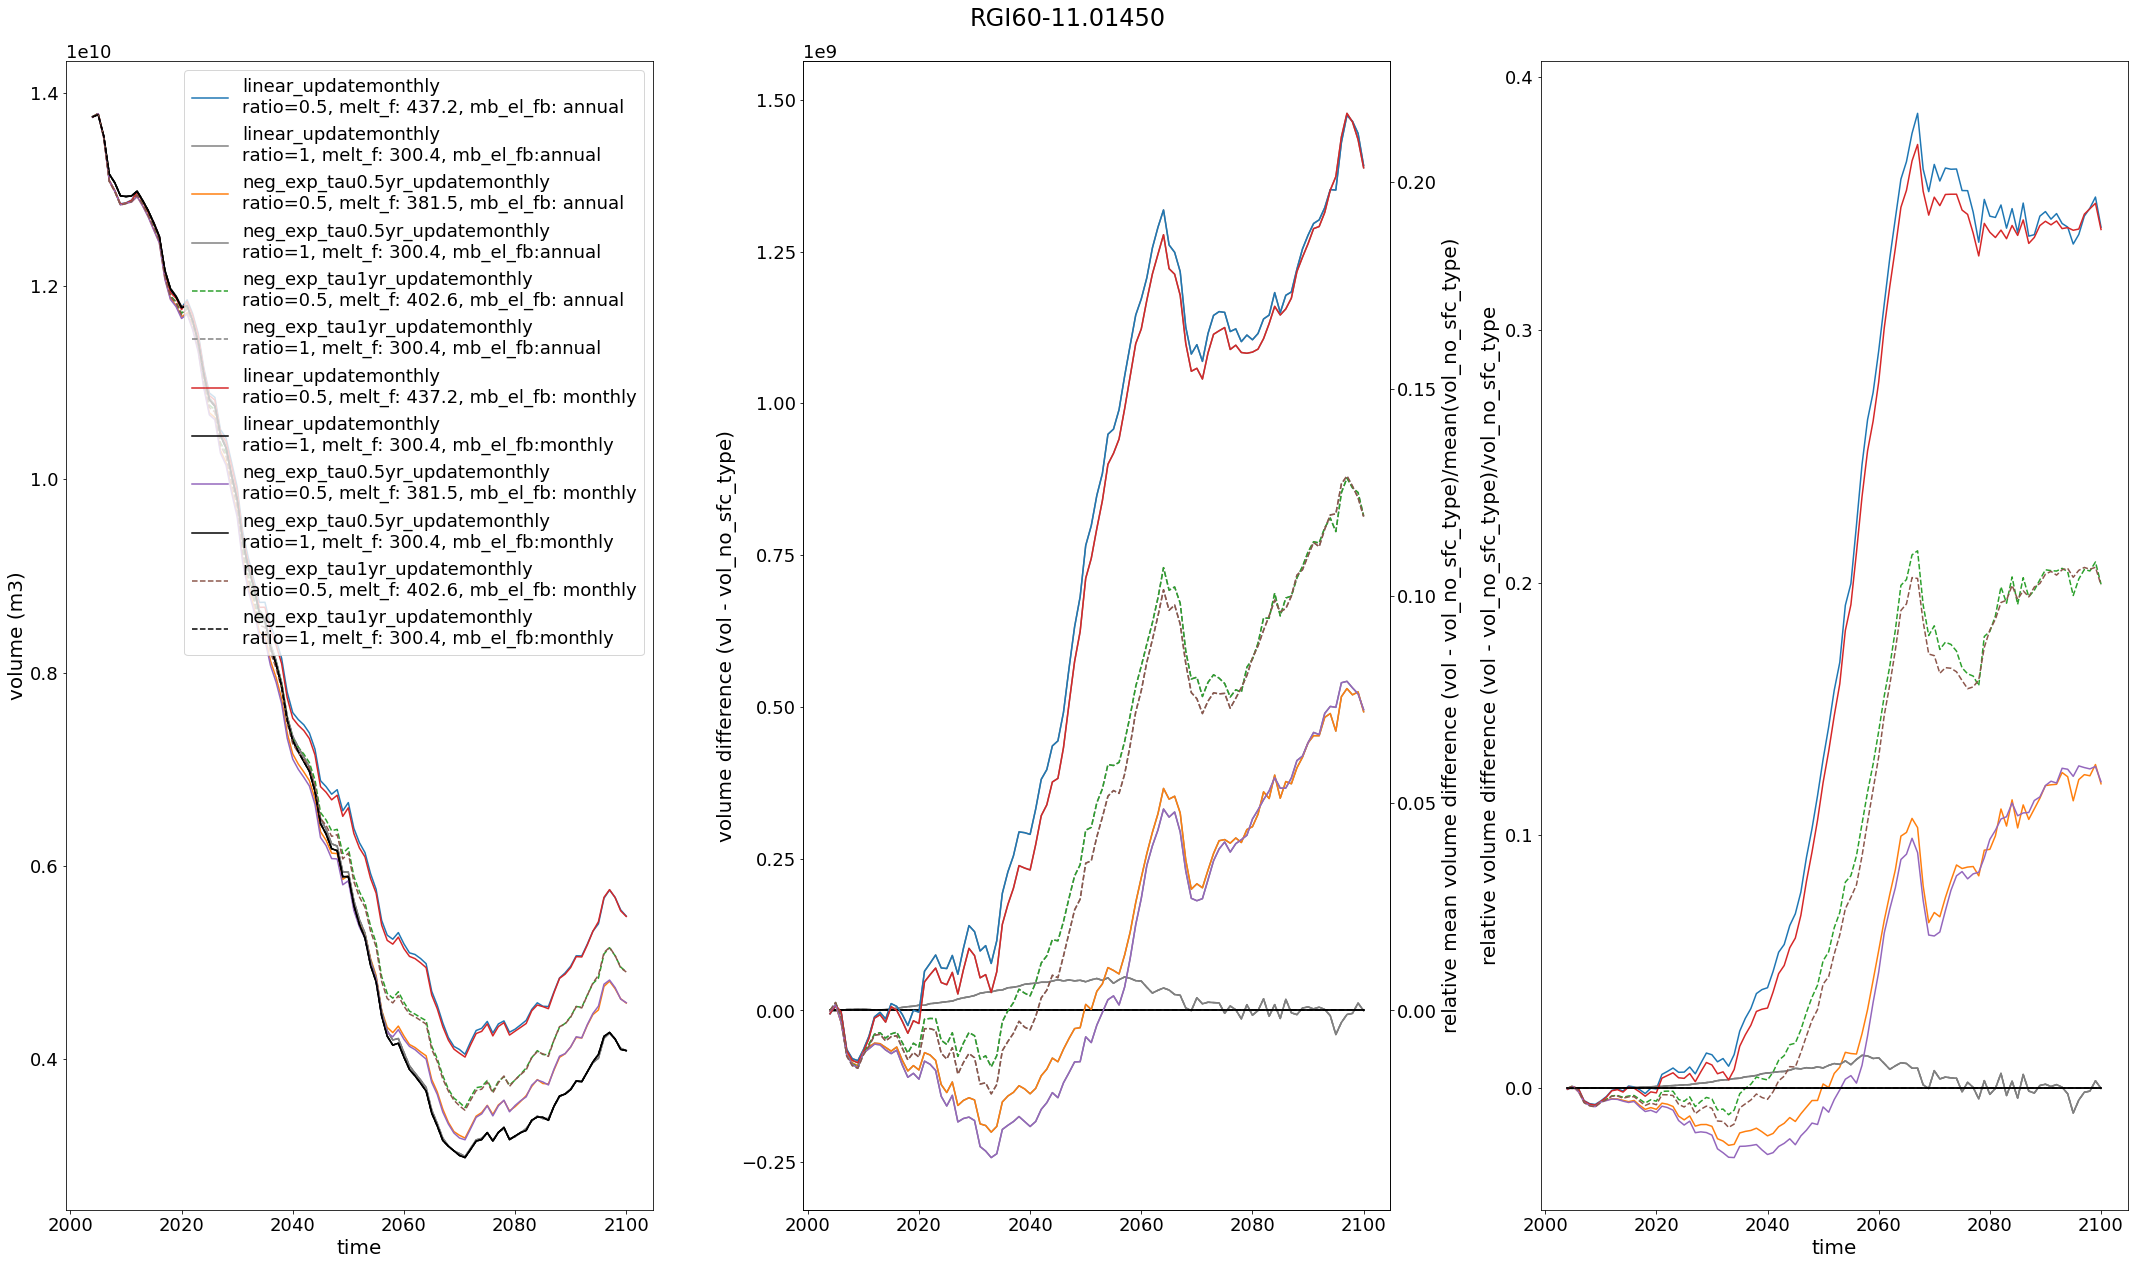

In [19]:
pd_ds_ratio1 = pd.DataFrame(ds_ratio1, index =np.arange(2004,2101,1))
#assert np.all(pd_ds_ratio1.std(axis=1) == 0)
#pd_ds[pd_ds.columns[2:]].std(axis=1)

plt.figure(figsize=(30,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
col={'annual':'grey', 'monthly':'black'}
plt.subplot(131)
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f = melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, update, melt_f, mb_el_fb)
                    else:
                        label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, tau, update, melt_f, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1), ds_plot,
                             label = label, ls = ls[j])
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, update, melt_f_1, mb_el_fb)
                    else:
                        label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, tau, update, melt_f_1, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1),
                             ds_plot_ratio1, label = label_1,
                             ls = ls[j], color=col[mb_el_fb])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    #((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()).plot(secondary_y=True, ax=ax2)
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
                    ax.plot(ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color=col[mb_el_fb]);
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean())
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax2.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()), ls = ls[j])

ax2.set_ylabel('relative mean volume difference (vol - vol_no_sfc_type)/mean(vol_no_sfc_type)')
ax.set_ylabel('volume difference (vol - vol_no_sfc_type)')
plt.xlabel('time')

plt.subplot(133)
ax = plt.gca()
for mb_el_fb in ['annual', 'monthly']:
    for update in ['monthly']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j])
                    ax.plot(((ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j],
                           color = col[mb_el_fb])

ax.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/vol_no_sfc_type')
plt.xlabel('time')
plt.tight_layout()


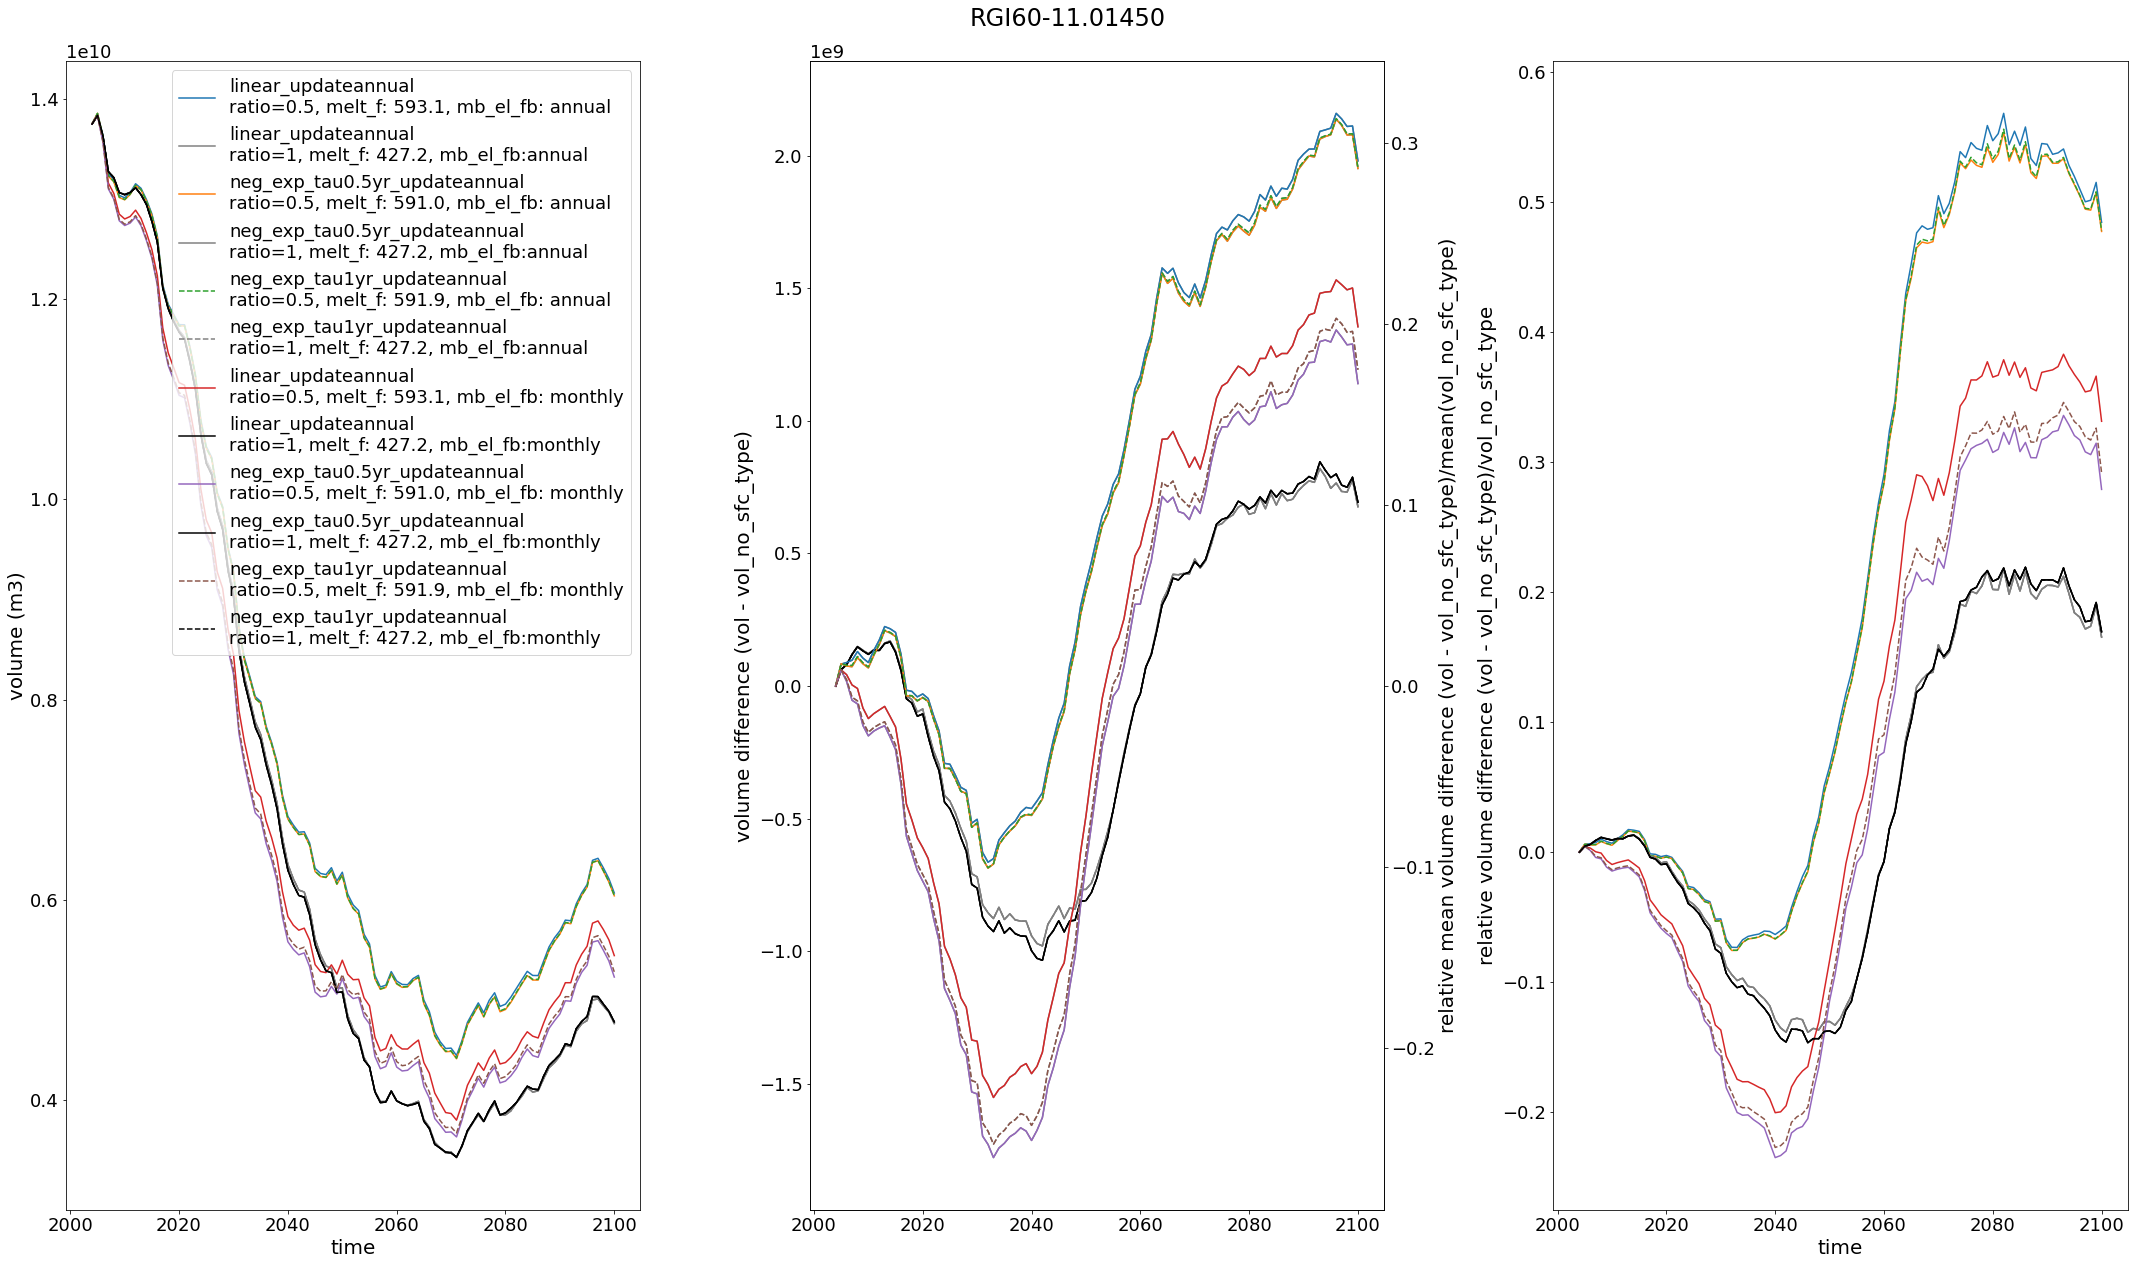

In [55]:
plt.figure(figsize=(30,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
col={'annual':'grey', 'monthly':'black'}
plt.subplot(131)
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f = melt_fs['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, update, melt_f, mb_el_fb)
                    else:
                        label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}, mb_el_fb: {}'.format(mfc, tau, update, melt_f, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1), ds_plot,
                             label = label, ls = ls[j])
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    if mfc == 'linear':
                        label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, update, melt_f_1, mb_el_fb)
                    else:
                        label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}, mb_el_fb:{}'.format(mfc, tau, update, melt_f_1, mb_el_fb)
                    plt.plot(np.arange(2004,2101,1),
                             ds_plot_ratio1, label = label_1,
                             ls = ls[j], color=col[mb_el_fb])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    #((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()).plot(secondary_y=True, ax=ax2)
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
                    ax.plot(ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color=col[mb_el_fb]);
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean())
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax2.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()), ls = ls[j])

ax2.set_ylabel('relative mean volume difference (vol - vol_no_sfc_type)/mean(vol_no_sfc_type)')
ax.set_ylabel('volume difference (vol - vol_no_sfc_type)')
plt.xlabel('time')

plt.subplot(133)
ax = plt.gca()
for mb_el_fb in ['annual', 'monthly']:
    for update in ['annual']: # '', 'monthly']:
        for mfc in ['linear', 'neg_exp']:
            for j, tau in enumerate([0.5, 1]):
                if mfc == 'linear' and tau == 1:
                    pass
                else:
                    ds_plot = ds['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]
                    ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}_mb_fb_{}'.format(mfc, tau, update, mb_el_fb)]

                    ax.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j])
                    ax.plot(((ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j],
                           color = col[mb_el_fb])

ax.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/vol_no_sfc_type')
plt.xlabel('time')
plt.tight_layout()


# trash, old stuff

KeyError: 'multiprocessing'

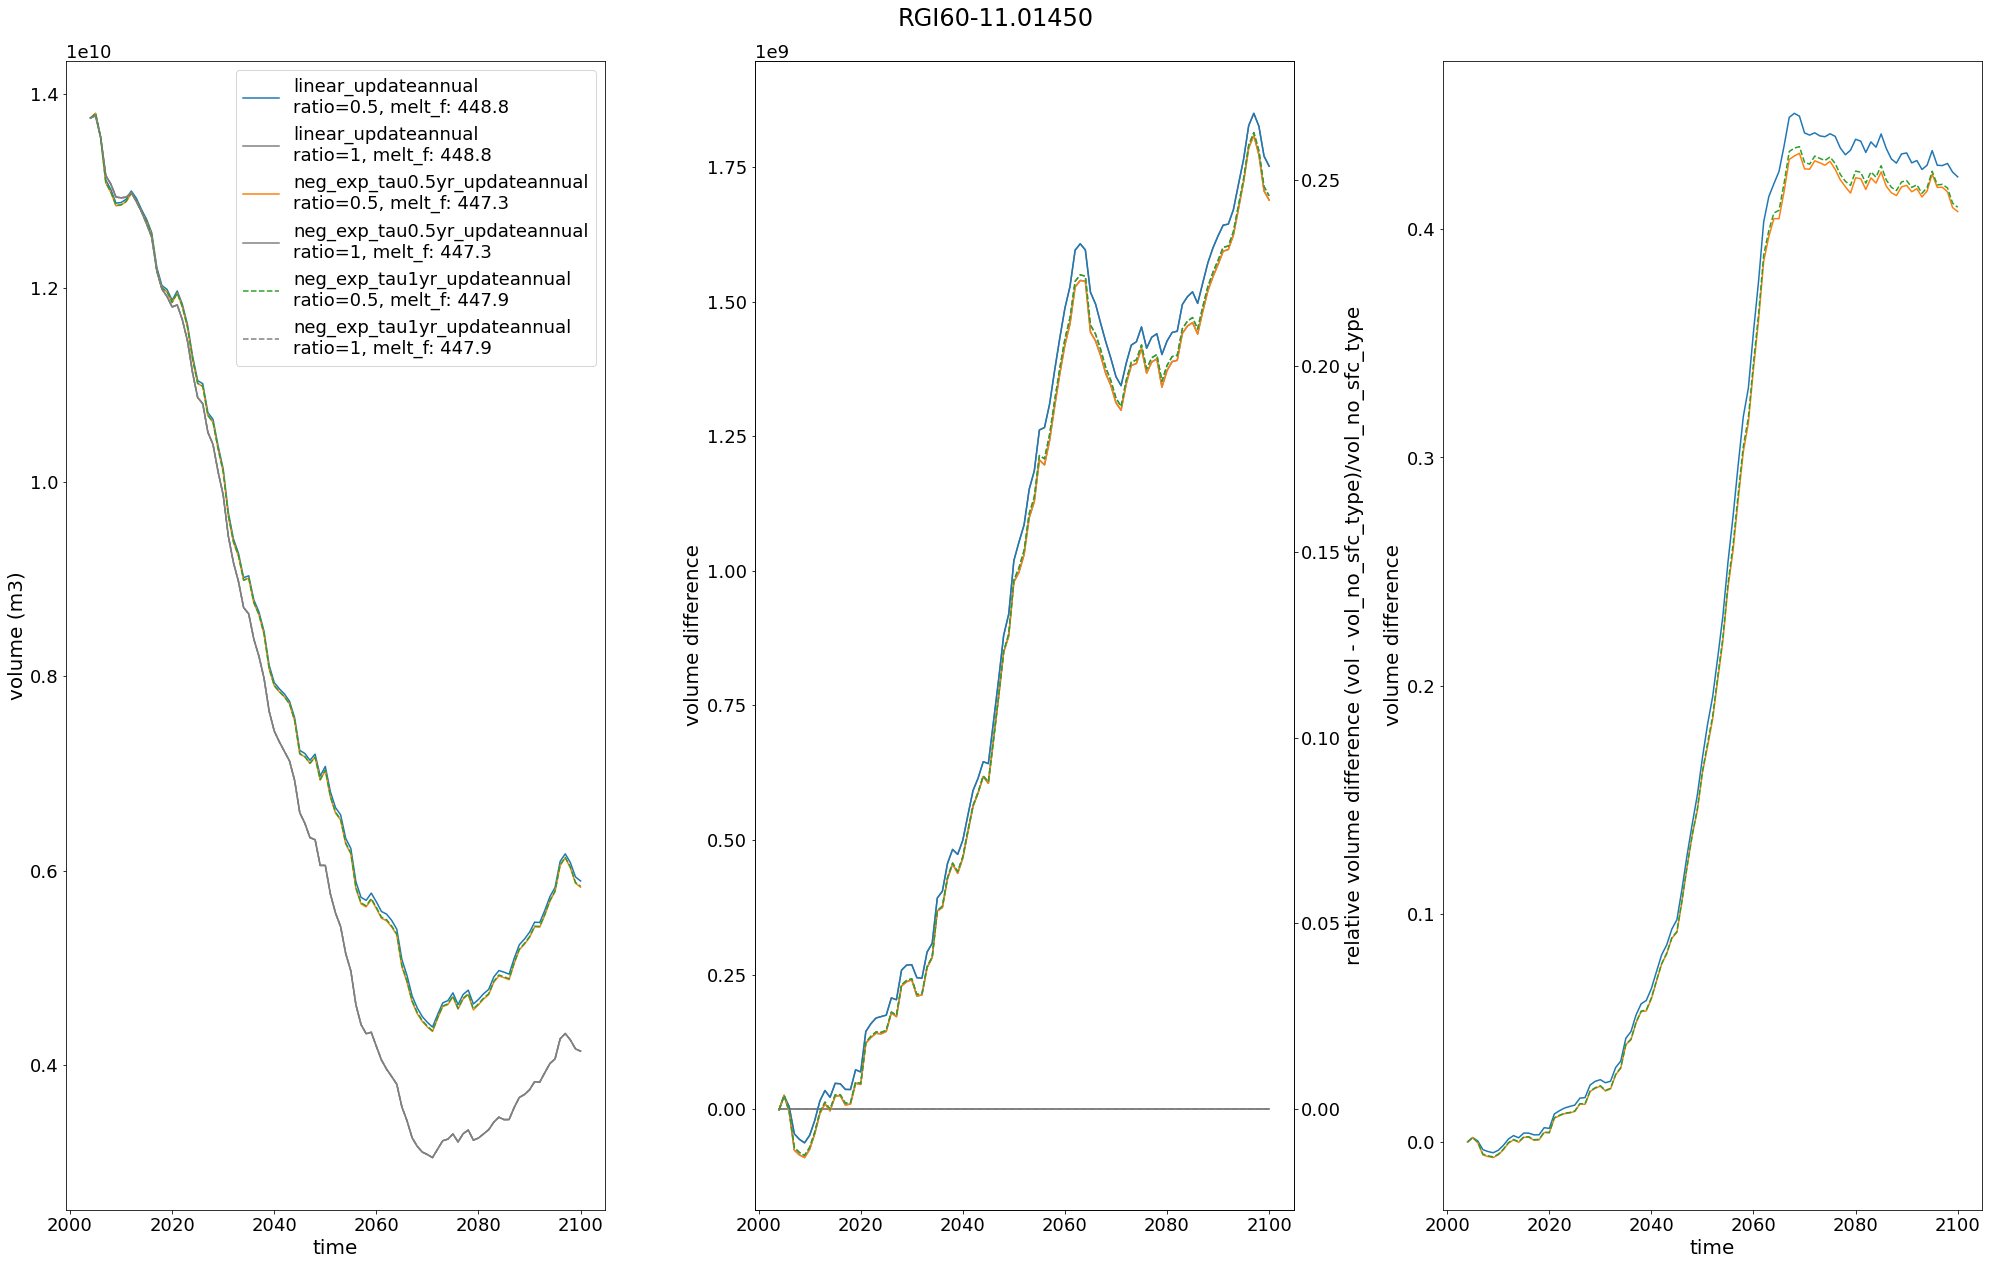

In [114]:
plt.figure(figsize=(28,18))
plt.suptitle(gdirs[-1].rgi_id)
ls = ['-', '--']
plt.subplot(131)
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                melt_f = melt_fs['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                melt_f_1 = melt_fs_ratio1['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                if mfc == 'linear':
                    label = '{}_update{}\nratio=0.5, melt_f: {:0.1f}'.format(mfc, update, melt_f)
                else:
                    label = '{}_tau{}yr_update{}\nratio=0.5, melt_f: {:0.1f}'.format(mfc, tau, update, melt_f)
                plt.plot(np.arange(2004,2101,1), ds_plot,
                         label = label, ls = ls[j])
                ds_plot_ratio1 = ds_ratio1['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                if mfc == 'linear':
                    label_1 = '{}_update{}\nratio=1, melt_f: {:0.1f}'.format(mfc, update, melt_f)
                else:
                    label_1 = '{}_tau{}yr_update{}\nratio=1, melt_f: {:0.1f}'.format(mfc, tau, update, melt_f)
                plt.plot(np.arange(2004,2101,1),
                         ds_plot_ratio1, label = label_1,
                         color = 'grey', ls = ls[j])
plt.ylabel('volume (m3)')
plt.xlabel('time')
plt.legend()
plt.subplot(132)
ax=plt.gca()

pd_ds = pd.DataFrame(ds, index =np.arange(2004,2101,1))
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]
                #((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()).plot(secondary_y=True, ax=ax2)

                ax.plot(ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
                ax.plot(ds_plot_ratio1-pd_ds_ratio1[pd_ds_ratio1.columns[0]], ls = ls[j], color = 'grey');
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim()/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean())
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]

                ax2.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]].mean()), ls = ls[j])

ax2.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/mean(vol_no_sfc_type)')
ax.set_ylabel('volume difference')
plt.xlabel('time')

plt.subplot(133)
ax = plt.gca()
for update in ['annual']: # '', 'monthly']:
    for mfc in ['linear', 'neg_exp']:
        for j, tau in enumerate([0.5, 1]):
            if mfc == 'linear' and tau == 1:
                pass
            else:
                ds_plot = ds['{}_tau{}yr_update{}'.format(mfc, tau, update)]

                ax.plot(((ds_plot-pd_ds_ratio1[pd_ds_ratio1.columns[0]])/pd_ds_ratio1[pd_ds_ratio1.columns[0]]), ls = ls[j])

ax2.set_ylabel('relative volume difference (vol - vol_no_sfc_type)/vol_no_sfc_type')
ax.set_ylabel('volume difference')
plt.xlabel('time')
plt.tight_layout()


In [66]:
pd_ds_ratio1 = pd.DataFrame(ds_ratio1, index =np.arange(2004,2101,1))
assert np.all(pd_ds_ratio1.std(axis=1) == 0)
pd_ds[pd_ds.columns[2:]].std(axis=1)

2004    1.249339e+04
2005    2.723507e+05
2006    1.654104e+06
2007    3.433625e+06
2008    3.150611e+06
            ...     
2096    3.390237e+06
2097    3.839342e+06
2098    5.140739e+06
2099    5.794564e+06
2100    5.514934e+06
Length: 97, dtype: float64

- differences between neg. exponential and linear are < 1% ? (at least for HEF)

In [65]:
pd_ds.columns

Index(['linear_tau0.5yr_updateannual', 'linear_tau1yr_updateannual',
       'neg_exp_tau0.5yr_updateannual', 'neg_exp_tau1yr_updateannual'],
      dtype='object')

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035,
       2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046,
       2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068,
       2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079,
       2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100])

In [7]:
# now the same using constant climate --> with run_task: run_constant_climate_TIModel, but don't need `seed` and `unique samples`
workflow.execute_entity_task(run_constant_climate_TIModel, gdirs,
                             #run_task=run_constant_climate_TIModel, #run_random_climate_TIModel
                             #store_monthly_hydro=True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2003, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, #seed=0, 
                             store_monthly_step=False,
                             output_filesuffix='_constant_spinup_test',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             mb_model_sub_class = TIModel_Sfc_Type,
                             kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'linear'},
                             mb_elev_feedback = 'never'
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_constant_spinup_test')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


2021-07-15 14:16:00: oggm.workflow: Execute entity task run_constant_climate_TIModel on 2 glaciers


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0
the heights should correspond to the inversion heights
(shapes (326,), (15,) mismatch)
 x: array([2062., 2072., 2082., 2092., 2102., 2112., 2122., 2132., 2142.,
       2152., 2162., 2172., 2182., 2192., 2202., 2212., 2222., 2232.,
       2242., 2252., 2262., 2272., 2282., 2292., 2302., 2312., 2322.,...
 y: array([3322.181163, 3303.609086, 3284.610814, 3267.962571, 3251.295859,
       3234.061485, 3215.490023, 3195.688196, 3176.466321, 3157.502204,
       3138.847615, 3120.84884 , 3102.934194, 3084.806396, 3066.79597 ])

In [8]:
h,w = gdir.get_inversion_flowline_hw()

In [15]:
fls = gdir.read_pickle('model_flowlines')

In [12]:
from MBsandbox.mbmod_daily_oneflowline import MultipleFlowlineMassBalance_TIModel

In [31]:
mb_mod = MultipleFlowlineMassBalance_TIModel(gdir, melt_f = 300, #fls=fls,
                                    mb_type=mb_type,
                                    mb_model_class = TIModel,
                                             prcp_fac=1,#_Sfc_Type,
                                    #melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                    #      melt_f_update='monthly',
                                   input_filesuffix=climate_type)

In [41]:
mb_mod.fls[-1].dx_meter

100.0

In [32]:
mb_mod.get_annual_mb(mb_mod.fls[-1].surface_h, fl_id=-1)

TypeError: object of type 'NoneType' has no len()

In [26]:
len(mb_mod.fls[-1].surface_h)

152

In [9]:
# with normal spinup for 5 years
mb_geodetic = pd_geodetic.loc[gdir.rgi_id].dmdtda * 1000
years = np.arange(2000,2020,1)
mb_mod_monthly_0_5_m = TIModel_Sfc_Type(gdir, 300, mb_type=mb_type,
                                          melt_f_ratio_snow_to_ice=0.5, prcp_fac=pf,
                                          melt_f_update='monthly',
                                          baseline_climate=climate_type)
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 1, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1446: UserWarning: Attention: this has not been tested enough to be sure that                 it works
  warnings.warn('Attention: this has not been tested enough to be sure that \
/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1446: UserWarning: Attention: this has not been tested enough to be sure that                 it works
  warnings.warn('Attention: this has not been tested enough to be sure that \
/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1446: UserWarning: Attention: this has not been tested enough to be sure that                 it works
  warnings.warn('Attention: this has not been tested enough to be sure that \
/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1446: UserWarning: Attention: this has not been tested enough to be sure that                 it works
  warnings.warn('Attention: this has not b